# Flawed steel cased wells

[Lindsey Heagy](http://github.com/lheagy)

This notebook was used to produce Figures 1, 2, 4, 5, 6, 9, 10, 11 in Heagy and Oldenburg, 2018. It is organized in 6 experiments, indicated in the second code-cell below. 

In [1]:
# core python
import numpy as np
import scipy.sparse as sp
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib import patches
from matplotlib import gridspec
import matplotlib.lines as mlines
import ipywidgets
from string import ascii_lowercase

# SimPEG and related
import discretize
from discretize import utils
from SimPEG import Utils, Maps
from SimPEG.Survey import Data
from pymatsolver import Pardiso

# utilities for casing simulations
import casingSimulations as casingSim

%matplotlib inline

Select an experiment to run. In all, we consider a 1000m long well and examine the impact of a flaw on the behaviour of the fields, fluxes, charges and electric field data at the surface. The experiments are as follows

1. Well with a 10m flaw (full circumference) at 500m depth. We compare this with an intact well and a short, 500m long well. This experiment produces Figures 1, 2 and 4 in Heagy and Oldenburg, 2018

2. Flawed well and the depth of the flaw is varied (300m depth to 900m depth). This experiment was used to produce Figure 5

3. Well with a 10m flaw at 500m depth - the conductivity of the background is varied. This experiment was used to produce Figure 6

4. Well with a partial flaw (50% of circumference) and vary the length of the flaw. This was use to produce Figure 11

5. Additional experiment to comare a partial flaw with an intact well where the flawed region of the well is replaced with a lower conductivity such that the conductance of the flawed region is equal in both cases

6. Well with a 10m flaw at 500m depth and the conductivity of the well is varied. This was used to produce Figures 9, 10


In [2]:
experiment = 1  # 1000 m well, break at 500m, compare with short well
# experiment = 2  # 1000 m well, examine break at every 200m 
# experiment = 3  # 1000 m well, vary the conductivity of the background
# experiment = 4 # flawed well - partial flaw, vary the length
# experiment = 5 # flawed well - partial flaw, vary the length, compare with equal conductance
# experiment = 6 # flawed well, compare different well conductivities

##  Parameters

To examine the impact of replacing the steel cased well with a solid well, I have run a few simulations using SimPEG and simulating the DC resistivity equations using a finite volume approach on a 3D cylindrical mesh.  

In [3]:
simDir = 'Flawed_DC'  # create a simulation directory where results can be saved. 

In [4]:
casing_l = 1000  # 1km long casing
sigma_back = 1e-1  # 0.1 S/m background
casing_d = 10e-2 # 10cm diameter
casing_t = 1e-2  # 1cm thickness

In [5]:
model = casingSim.model.FlawedCasingInHalfspace(
    directory=simDir,
    sigma_casing= 5e6,  # conductivity of the casing (S/m)
    sigma_back = sigma_back,  # conductivity of the background (S/m)
    sigma_inside = sigma_back,  # fluid inside the well has same conductivity as the background
    sigma_air = 1e-4,   # conductivity of the air
    casing_d = casing_d-casing_t,  # 10cm is outer casing diameter
    casing_l = casing_l,
    casing_t = casing_t, 
    src_a = np.r_[0., 3*np.pi/2., -1.25],  # put the A electrode just below the surface
    src_b = np.r_[1*casing_l, 3*np.pi/2., -1.25] # put the return electrode at a distance of 2 x length of well away
)

# adjust the src_a location so it is connected to well
model.src_a = np.r_[model.casing_r, 3*np.pi/2., -1.25]  

In [6]:
# Here we print the parameters being used to set up the simulation
model.serialize()

{'__class__': 'FlawedCasingInHalfspace',
 'casing_d': 0.09000000000000001,
 'casing_l': 1000.0,
 'casing_t': 0.01,
 'casing_top': 0.0,
 'directory': 'Flawed_DC',
 'filename': 'ModelParameters.json',
 'flaw_r': [0.0, 0.0],
 'flaw_theta': [0.0, 6.283185307179586],
 'flaw_z': [0.0, 0.0],
 'mur_back': 1.0,
 'mur_casing': 1.0,
 'mur_flaw': 1.0,
 'sigma_air': 0.0001,
 'sigma_back': 0.1,
 'sigma_casing': 5000000.0,
 'sigma_flaw': 5500000.0,
 'sigma_inside': 0.1,
 'src_a': [0.045000000000000005, 4.71238898038469, -1.25],
 'src_b': [1000.0, 4.71238898038469, -1.25],
 'surface_z': 0.0,
 'version': '0.0.5'}

In [7]:
copiedmodelparams = {
    key: val for key, val in model.serialize().items() 
    if key in dir(casingSim.model.CasingInHalfspace) and not key.startswith('_') 
}

In [8]:
background = casingSim.model.CasingInHalfspace(
    **copiedmodelparams
)

### Set up the models

In [9]:
flaw_depth = 500.  # depth to the top of the flaw
flaw_h = 10. # vertical extent of the flaw

In [10]:
model.flaw_r = np.r_[model.casing_a, model.casing_b]
model.flaw_z = np.r_[-flaw_h, 0] - flaw_depth
model.sigma_flaw = model.sigma_back

In [11]:
# 1000 m well, break at 500m, compare with short well
if experiment == 1:  
    short_casing = model.copy()
    short_casing.flaw_z = np.r_[-casing_l, model.flaw_z[1]]
    partial_flaw = model.copy()
        
    flawed_models = {'flawed': model, 'short': short_casing}

In [12]:
# 1000 m well, examine break at every 200m 
if experiment == 2: 
    flaw_h = 10  
    start = 100  
    step = 200
    examples = [start + step*(i) for i in range(int(np.floor(casing_l/step)))]

    flawed_models = {}

    for ex in examples:
        tmp = model.copy()
        tmp.flaw_z = np.r_[-flaw_h, 0] - ex
        flawed_models['flaw_{}'.format(ex)] = tmp

In [13]:
# 1000 m well, vary the conductivity of the background
if experiment == 3:
    
    sigma_background = np.r_[1e-2, 3e-2, 1e-1, 3e-1, 1]
    
    flawed_models = {}
    baseline_models = {}
    
    for sig in sigma_background:
        tmp_flawed = model.copy()
        tmp_flawed.sigma_back = sig
        tmp_flawed.sigma_flaw = sig
        tmp_flawed.sigma_inside = sig
        
        tmp_baseline = background.copy()
        tmp_baseline.sigma_back = sig
        tmp_baseline.sigma_inside = sig
        
        flawed_models['flaw_{}'.format(sig)] = tmp_flawed
        baseline_models['baseline_{}'.format(sig)] = tmp_baseline

In [14]:
# experiment = 4: flawed well - partial flaw, vary the length
# experiment = 5: flawed well - partial flaw, vary the length, compare with equal conductance
if experiment in [4, 5]: 
    
    flaw_extent = np.r_[10, 30, 100, 300]
    
    flawed_models = {}
    partial_models = {}
    
    for extent in flaw_extent:
        tmp_flawed = model.copy()
        tmp_partial  = model.copy()
        
        tmp_flawed.flaw_z = -flaw_depth - np.r_[extent, 0]
        tmp_partial.flaw_z = -flaw_depth - np.r_[extent, 0]
        
        if experiment == 5:
            tmp_flawed.flaw_r = np.r_[tmp_flawed.casing_a, tmp_flawed.casing_b]
            tmp_flawed.sigma_flaw = 0.5 * tmp_flawed.sigma_casing
        
        flawed_models["flaw_{}".format(extent)] = tmp_flawed
        partial_models["partial_{}".format(extent)] = tmp_partial

In [15]:
# experiment = 6 # flawed well, compare different well conductivities
if experiment == 6:
    
    sigma_casing = np.r_[5e5, 5e6, 5e7]
    
    flawed_models = {}
    baseline_models = {}
    
    for sig in sigma_casing:
        tmp_flawed = model.copy()
        tmp_flawed.sigma_casing = sig
        
        tmp_baseline = background.copy()
        tmp_baseline.sigma_casing = sig
        
        flawed_models['flaw_{}'.format(sig)] = tmp_flawed
        baseline_models['baseline_{}'.format(sig)] = tmp_baseline

## Mesh

Here we set up a 3D cylindrical mesh, discretizing in $x$, $\theta$ and $z$. 

To discretize in x, we start by defining the finest region of the mesh, ensuring that we have 4 cells across the thickness of the casing. From there, we expand the cell sizes until we reach the second uniform cell size we want to model at (`csx2`). We then use a constant cell spacing of `csx2` until we have meshed out to the end of the domain in which we want to examine data (`domainx2`). Beyond that, we add padding cells to *"infinity"*

In [16]:
# theta discretization
hy = np.ones(16)
hy = hy*2*np.pi / hy.sum()

In [17]:
# parameters defining the core region of the mesh
# note that the finest re
csx2 = 50.  # cell size in the x-direction in the second uniform region of the mesh (where we measure data)
csz = 2.5  # cell size in the z-direction 
domainx2 = 1000  # go out 500m from the well

# padding parameters
npadx, npadz = 15, 22  # number of padding cells
pfx2 = 1.4  # expansion factor for the padding to infinity in the x-direction
pfz = 1.4

# set up a mesh generator which will build a mesh based on the provided parameters
# and casing geometry
cylMeshGen = casingSim.CasingMeshGenerator(
    directory=simDir,  # directory where we can save things
    modelParameters=model,  # casing parameters
    npadx=npadx,  # number of padding cells in the x-direction
    npadz=npadz,  # number of padding cells in the z-direction
    domain_x=domainx2,  # extent of the second uniform region of the mesh 
    hy=hy,   # cell spacings in the 
    csx1=model.casing_t/4.,  # use at least 4 cells per across the thickness of the casing
    csx2=csx2,  # second core cell size
    csz=csz,  # cell size in the z-direction
    pfx2=pfx2,  # padding factor to "infinity"
    pfz=pfz  # padding factor to "infinity" for the z-direction
)

/anaconda3/lib/python3.6/site-packages/matplotlib/projections/polar.py:58: RuntimeWarning: invalid value encountered in less
  mask = r < 0


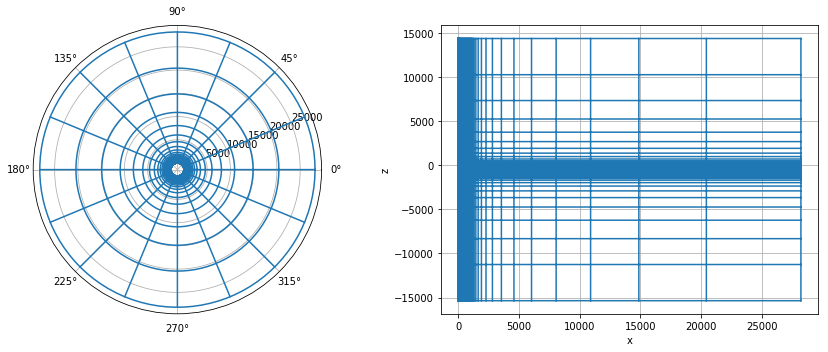

In [18]:
cylMeshGen.mesh.plotGrid()

In [19]:
src_theta = cylMeshGen.hy[0]/2. + np.pi
model.src_a[1] = src_theta
model.src_b[1] = src_theta

(0.0, 3000.0)

/anaconda3/lib/python3.6/site-packages/matplotlib/projections/polar.py:58: RuntimeWarning: invalid value encountered in less
  mask = r < 0


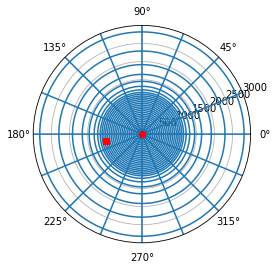

In [20]:
# Plot the source location

ax = plt.subplot(111, projection='polar')
cylMeshGen.mesh.plotGrid(ax=ax, slice='z')
ax.plot(model.src_a[1], model.src_a[0], 'ro')
ax.plot(model.src_b[1], model.src_b[0], 'rs')
ax.set_ylim([0., 3*model.casing_l])

In [21]:
# define partial flaw for partially flawed models
if experiment in [4, 5]:
    flaw_theta = cylMeshGen.mesh.vectorNy[[0, 8]]
    for m in partial_models.values():
        m.flaw_theta = flaw_theta

In [22]:
# put the models in a dictionary for convienence 
if experiment in [1, 2]:
    modelDict = {'baseline': background}
    modelDict.update(flawed_models)
    model_names = ['baseline'] + sorted(flawed_models.keys())

elif experiment in [3, 6]:
    modelDict = baseline_models
    modelDict.update(flawed_models)
    model_names = sorted(baseline_models.keys())

elif experiment in [4, 5]:
    modelDict = {'baseline': background}
    modelDict.update(flawed_models)
    modelDict.update(partial_models)
    model_names = ['baseline'] + list(flawed_models.keys()) + list(partial_models.keys())
    
print(model_names)

['baseline', 'flawed', 'short']


In [23]:
for mod in modelDict.values():
    mod.src_a[1] = src_theta
    mod.src_b[1] = src_theta

In [24]:
# Assign physical properties on the mesh
physpropsDict = dict(
    [
        (name, casingSim.model.PhysicalProperties(cylMeshGen, mod)) 
        for name, mod in modelDict.items()
    ]
)

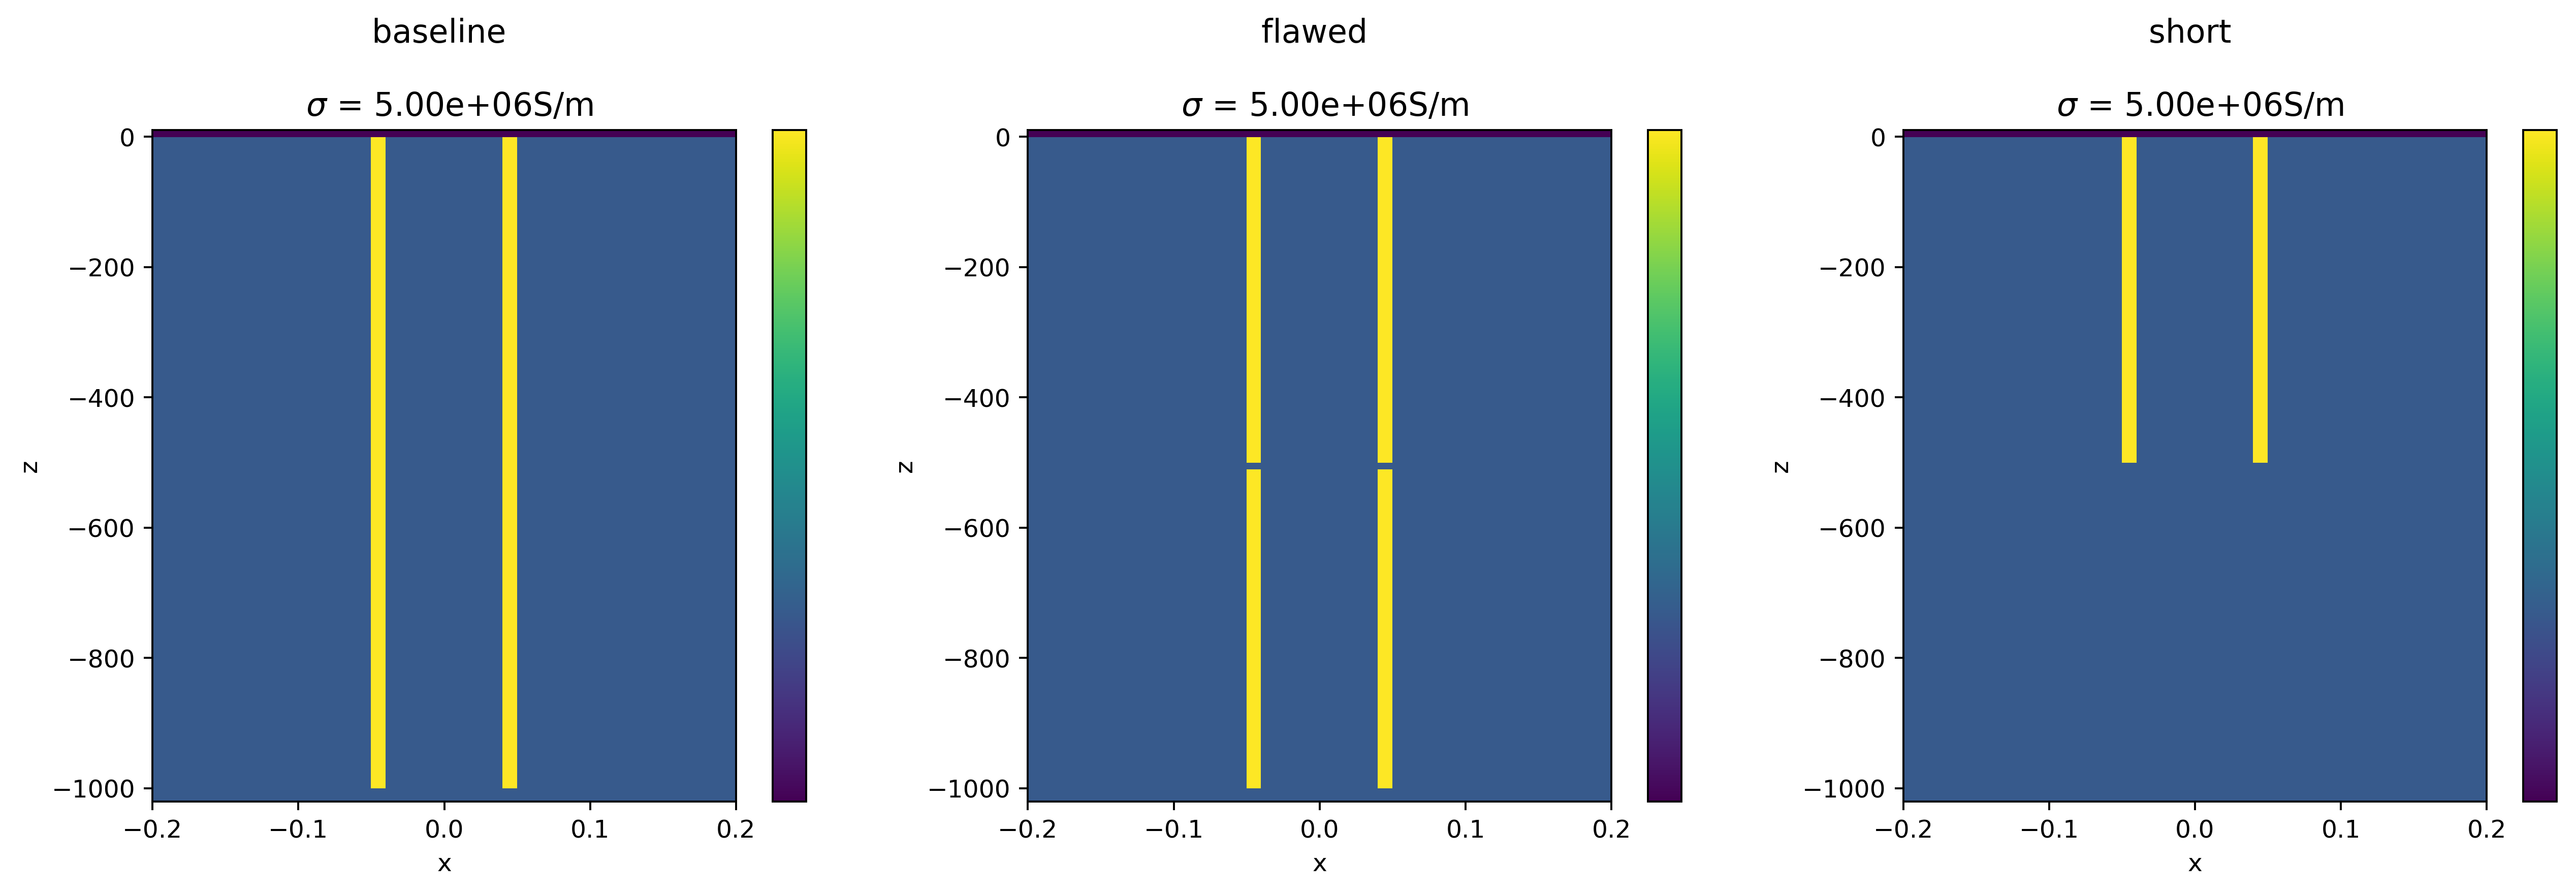

In [25]:
# Plot the models
xlim = 0.2*np.r_[-1, 1]  # x-limits in meters
zlim = np.r_[-casing_l -20, 10]
    

theta_ind = 10

plot_models = model_names

fig, ax = plt.subplots(1, len(plot_models), figsize=(6*len(plot_models), 5), dpi=350)
for a, title in zip(ax, plot_models):
    pp = physpropsDict[title]
    pp.plot_sigma(
        ax=a, 
        theta_ind=theta_ind,
        pcolorOpts={'norm':LogNorm()},  # plot on a log-scale
#         clim = [5e4, 5e8]
    )
    a.set_title('{} \n\n $\sigma$ = {:1.2e}S/m'.format(title, pp.modelParameters.sigma_casing), fontsize=13)
    a.set_xlim(xlim)
    a.set_ylim(zlim)

In [26]:
model.src_a, model.src_b

(array([ 0.045     ,  3.33794219, -1.25      ]),
 array([1000.        ,    3.33794219,   -1.25      ]))

In [27]:
# Set up 4 sources, top casing, top & not coupled, downhole, downhole not coupled

src_locs = [250, 500, 750, 2000]

src_b = np.vstack(
    [[loc, model.src_b[1], model.src_b[2]] for loc in src_locs]
)

src_a = np.ones((src_b.shape[0], 1)) * model.src_a

In [28]:
src_b

array([[ 2.50000000e+02,  3.33794219e+00, -1.25000000e+00],
       [ 5.00000000e+02,  3.33794219e+00, -1.25000000e+00],
       [ 7.50000000e+02,  3.33794219e+00, -1.25000000e+00],
       [ 2.00000000e+03,  3.33794219e+00, -1.25000000e+00]])

## set up a DC simulation

In [29]:
simDict = {}
for key in model_names:
    simDict[key] = casingSim.run.SimulationDC(
        modelParameters=modelDict[key], directory=simDir, 
        meshGenerator=cylMeshGen, src_a=src_a, src_b=src_b
    )


Homogeneous Dirichlet is the natural BC for this CC discretization.
Homogeneous Dirichlet is the natural BC for this CC discretization.
Homogeneous Dirichlet is the natural BC for this CC discretization.


In [30]:
%%time
fieldsDict = {}
for title in model_names:
    if title not in fieldsDict.keys():
        print('--- Running {} ---'.format(title))
        fieldsDict[title] = simDict[title].run(save=False)
        print('\n')

--- Running baseline ---
Validating parameters...
      max x: 28199.41672261712, min z: -15352.855805436326, max z: 14352.855805436311, nC: 682816
Starting SimulationDC
Using <class 'pymatsolver.direct.Pardiso'> Solver
   ... Done. Elapsed time : 54.51403188705444


--- Running flawed ---
Validating parameters...
      max x: 28199.41672261712, min z: -15352.855805436326, max z: 14352.855805436311, nC: 682816
Starting SimulationDC
Using <class 'pymatsolver.direct.Pardiso'> Solver
   ... Done. Elapsed time : 53.42029786109924


--- Running short ---
Validating parameters...
      max x: 28199.41672261712, min z: -15352.855805436326, max z: 14352.855805436311, nC: 682816
Starting SimulationDC
Using <class 'pymatsolver.direct.Pardiso'> Solver
   ... Done. Elapsed time : 59.6619508266449


CPU times: user 3min 47s, sys: 16.7 s, total: 4min 4s
Wall time: 2min 47s


## Plot Results

Here we plot the radial electric field along a line $90^{\circ}$ from the source. 

In [31]:
def plot_radial_efields(
    ax=None, key="baseline", src_ind=0, xlim=[5., 2000.], 
    theta_ind=1, color_ind=0, 
    label=None, include_baseline=True
):
    if ax is None:
        fig, ax = plt.subplots(1, 3, figsize=(12, 4), dpi=400)
    
    if label is None:
        label=key 
        
#     for i, key in enumerate(model_names):
    f = fieldsDict[key]
    src = simDict[key].survey.srcList[src_ind]
    baseline_src = simDict['baseline'].survey.srcList[src_ind]
    casingSim.view.plotLinesFx(
        cylMeshGen.mesh, field=np.absolute(f[src,'e']), pltType='semilogy',
        ax=ax[0], theta_ind=theta_ind, xlim=xlim, label=label, color_ind=color_ind
    )
    
    if include_baseline is True: 
        casingSim.view.plotLinesFx(
            cylMeshGen.mesh, field=np.absolute(fieldsDict['baseline'][baseline_src,'e']), pltType='semilogy',
            ax=ax[0], theta_ind=theta_ind, xlim=xlim, label='baseline' if label is None else None, 
            color='k'
        )
    
    casingSim.view.plotLinesFx(
        cylMeshGen.mesh,
        field=(
            np.absolute(f[src,'e'] - fieldsDict['baseline'][baseline_src,'e'])
        ),
        pltType='semilogy', ax=ax[1], theta_ind=theta_ind, xlim=xlim,
        label=label, color_ind=color_ind
    )
    
    casingSim.view.plotLinesFx(
        cylMeshGen.mesh,
        field=100*(
            np.absolute(f[src,'e'] - fieldsDict['baseline'][baseline_src,'e'])/
            (np.absolute(fieldsDict['baseline'][baseline_src,'e'])+1e-20)
        ),
        pltType='plot', ax=ax[2], theta_ind=theta_ind, xlim=xlim,
        label=label, color_ind=color_ind
    )

    ax[0].set_ylabel('Electric Field (V/m)')
    ax[1].set_ylabel('percent difference')
    
    ax[2].set_ylim([0., 100.])
    ax[0].set_title("{:1.1f}\n{:1.1f}".format(src_locs[src_ind], cylMeshGen.mesh.vectorCCy[theta_ind]*180/np.pi))
    
#     [a.set_ylim([1e-7, 1e-3]) for a in ax[:2]]
    [a.legend() for a in ax]

In [32]:
def widget_wrapper2(key, theta_ind):
    fig, ax = plt.subplots(1, 3, figsize=(10, 4), dpi=400)
    for src_ind in range(len(src_locs)-1):
        plot_radial_efields(
            key=key, src_ind=src_ind, theta_ind=theta_ind, ax=ax, 
            color_ind=src_ind, label="{:1.1e}".format(src_locs[src_ind]),
            include_baseline=False
        )
    ax[2].set_ylim([0, 200])
    plt.tight_layout()
    plt.show()
    
ipywidgets.interact(
    lambda key, theta_ind: widget_wrapper2(key, theta_ind),
    key=ipywidgets.ToggleButtons(options=model_names[1:], value=model_names[1]),
    src_ind=ipywidgets.IntSlider(min=0, max=len(src_locs)-1, value=0),
    theta_ind=ipywidgets.IntSlider(min=0, max=len(cylMeshGen.hy)-1, value=3)
)
# plot_radial_efields(ax=ax, src_ind=0)

interactive(children=(ToggleButtons(description='key', options=('flawed', 'short'), value='flawed'), IntSlider(value=3, description='theta_ind', max=15), Output()), _dom_classes=('widget-interact',))

<function __main__.<lambda>>

In [33]:
viewer = casingSim.FieldsViewer(
    sim_dict=simDict, fields_dict=fieldsDict, primary_key='baseline', model_keys=model_names
)

In [34]:
viewer.widget_cross_section(defaults={"min_depth":0, "max_depth":casing_l*1.25})

interactive(children=(FloatText(value=0.1, description='max_r'), FloatText(value=0.0, description='min_depth'), FloatText(value=1250.0, description='max_depth'), FloatText(value=0.0, description='clim_min'), FloatText(value=0.0, description='clim_max'), ToggleButtons(description='model_key', options=('baseline', 'flawed', 'short', 'all'), value='baseline'), ToggleButtons(description='view', options=('sigma', 'e', 'j', 'phi', 'charge', 'charge_density'), value='sigma'), ToggleButtons(description='prim_sec', options=('total', 'primary', 'secondary', 'percent'), value='total'), IntSlider(value=0, description='src_ind', max=3), IntSlider(value=0, description='theta_ind', max=15), Checkbox(value=False, description='show_mesh'), Checkbox(value=False, description='use_aspect'), Checkbox(value=True, description='casing_outline'), Output()), _dom_classes=('widget-interact',))

<function ipywidgets.widgets.interaction._InteractFactory.__call__.<locals>.<lambda>>

In [35]:
def plot_charge(
    ax=None, key=model_names[0], color_ind=0, color=None, src_ind=0, 
    label=None, secondary=False, linestyle='-', primary_key="baseline",
    marker=None
):
    if ax is None: 
        fig, ax = plt.subplots(1, 1, figsize=(5, 4)) #, dpi=400)
    
    f = fieldsDict[key]
    src = simDict[key].survey.srcList[src_ind]    
    plotme = f[src, 'charge']
    
    if secondary is True:
        f_prim = fieldsDict[primary_key]
        src_prim = simDict[primary_key].survey.srcList[src_ind]
        plotme = plotme - f_prim[src_prim, 'charge']
    z_charges, charges = casingSim.casing_charges(plotme, mesh, mod)
#     print(key, sum(charges))
    ax.plot(
        -z_charges, charges/csz, label=label, 
        color=color if color is not None else "C{}".format(color_ind), 
        linestyle=linestyle, marker=marker
    )
        

In [36]:
from matplotlib import rcParams
rcParams['font.size'] = 14

NameError: name 'mesh' is not defined

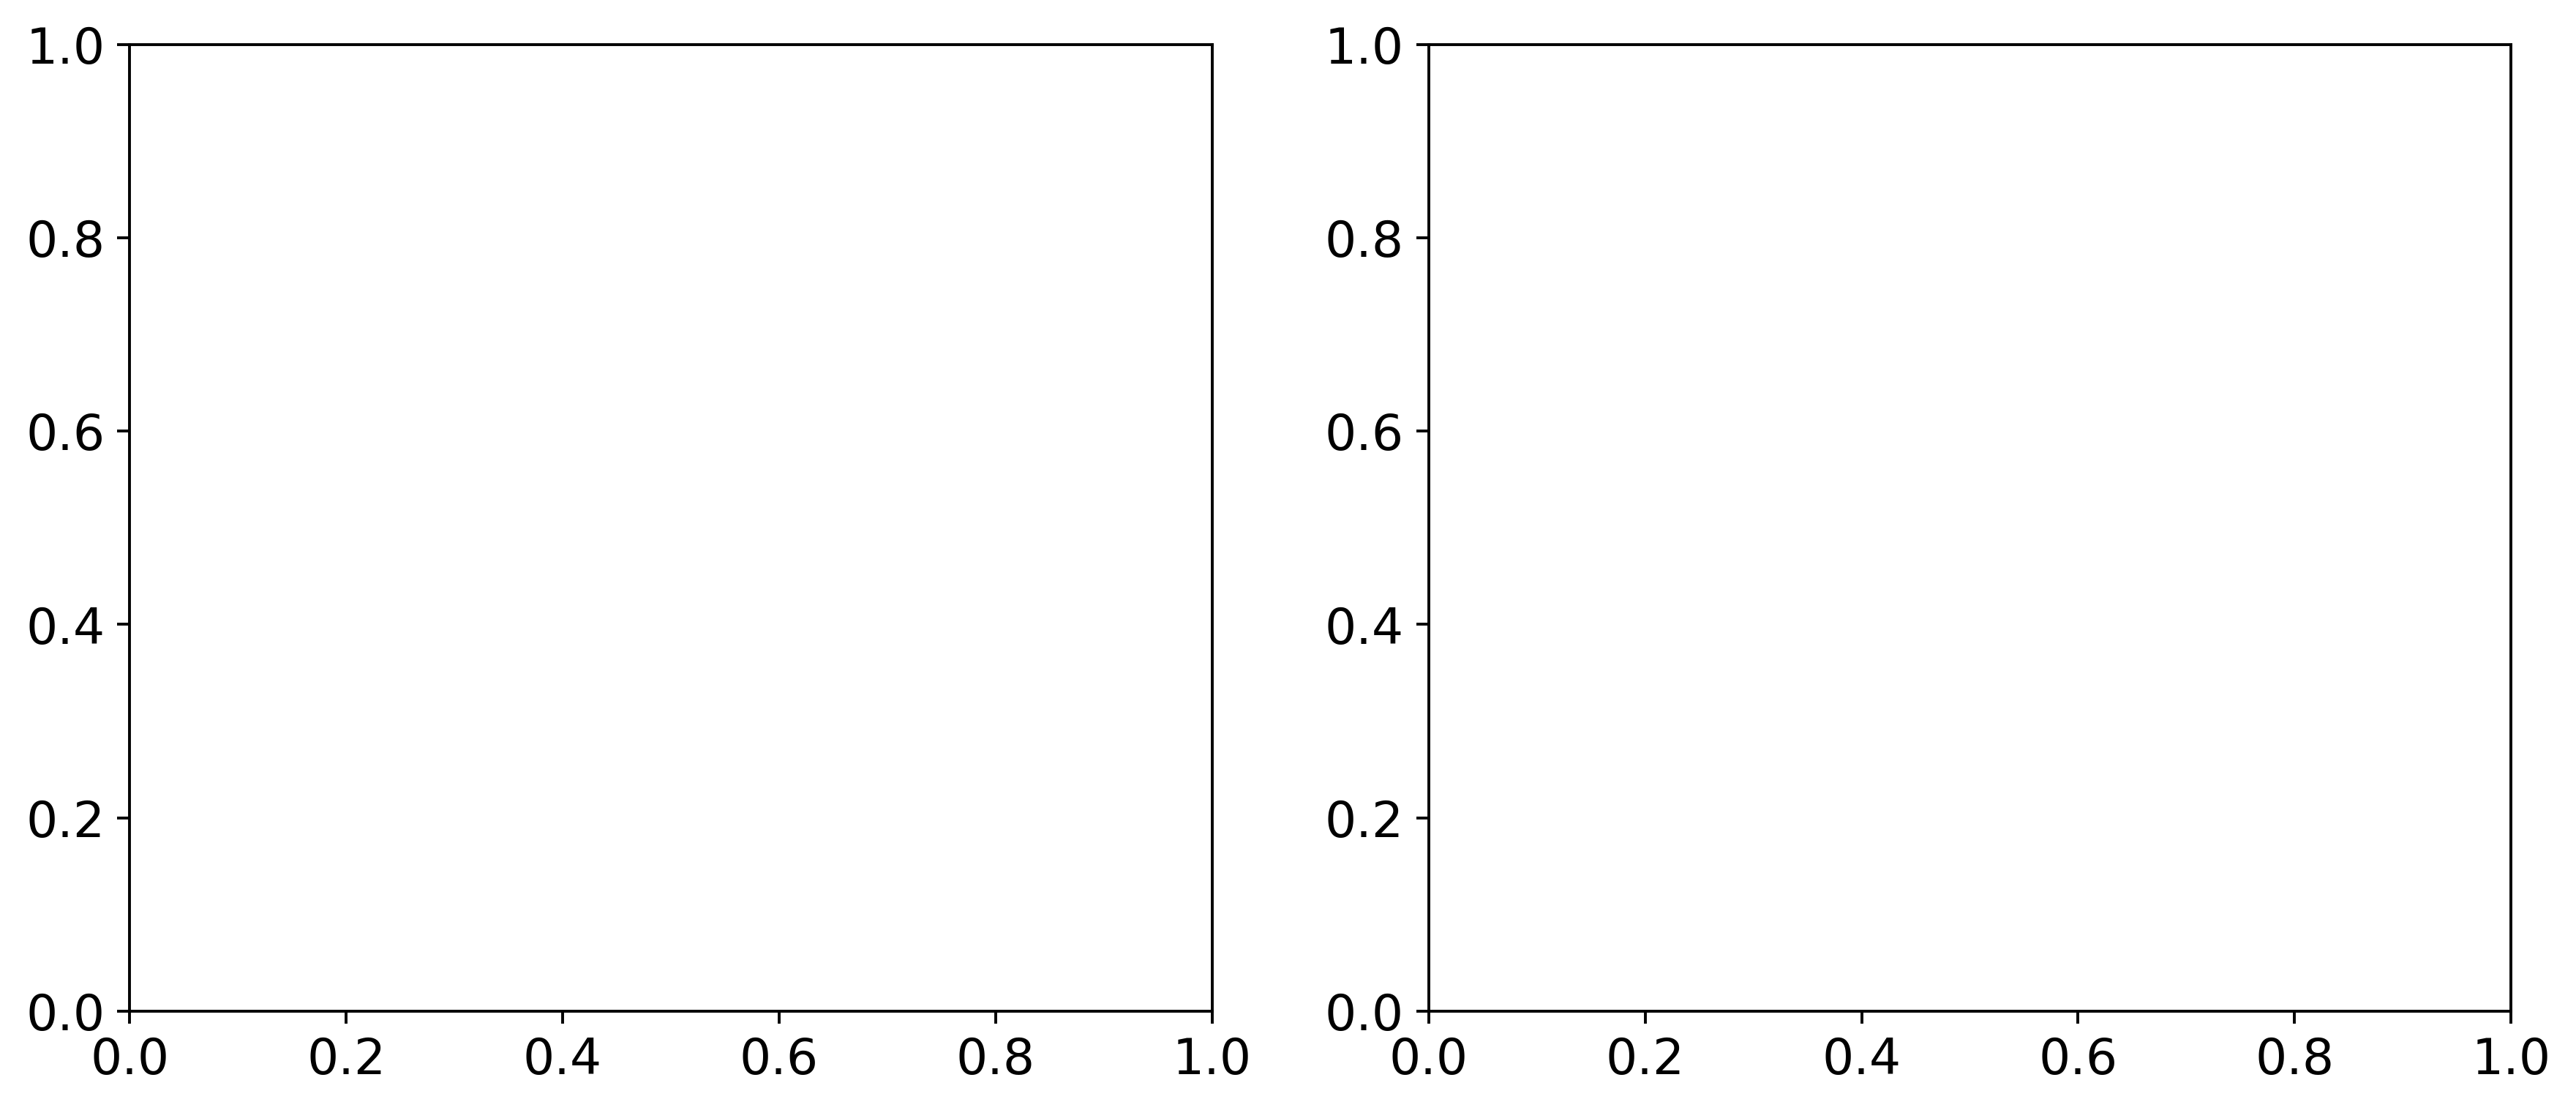

In [37]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5), dpi = 350)

primary_key = "baseline"
src_ind = len(simDict[model_names[0]].survey.srcList)-1

if experiment == 1:
    plot_models = ['baseline', 'short', 'flawed']

    for i, key in enumerate(plot_models):

        plot_charge(
            ax=ax[0], key=key, color_ind=0 if key != primary_key else None, 
            color = "k" if key == primary_key else "0.5" if key == "short" else None,
            src_ind=src_ind, label=key, linestyle = '-.' if key == "short" else None 
        )
        if key != primary_key:
            plot_charge(
                ax=ax[1], key=key, color_ind=0 if key != primary_key else None, 
                color = "k" if key == primary_key else "0.5" if key == "short" else None,
                src_ind=src_ind, label=key, secondary=True, linestyle = '-.' if key == "short" else None 
            )

    
elif experiment == 4:
    plot_charge(
        ax=ax[0], key=key, color = "k", src_ind=len(srcList)-1, label=key
    )
    for i, extent in enumerate(flaw_extent):
        flawed_key = "flaw_{}".format(extent)
        partial_key = "partial_{}".format(extent)
        
        plot_charge(
            ax=ax[0], key=flawed_key, color_ind=i, src_ind=src_ind, label="{} m".format(extent)
        )
        plot_charge(
            ax=ax[0], key=partial_key, color_ind=i, src_ind=src_ind, linestyle='--'
        )
        
        plot_charge(
            ax=ax[1], key=flawed_key, color_ind=i, src_ind=src_ind, label="{} m".format(extent), secondary=True
        )
        plot_charge(
            ax=ax[1], key=partial_key, color_ind=i, src_ind=src_ind, linestyle='--', secondary=True
        )
    
for i, a in enumerate(ax):
#     a.legend()
    a.set_xlabel('depth (m)')
    a.set_ylabel('charge per unit length (C/m)' if i == 0 else 'secondary charge per unit length (C/m)')
    a.set_title("({})".format(ascii_lowercase[i]))
    a.grid(which='both', alpha=0.4)

ax[0].legend(bbox_to_anchor=[2.57, 1])
# ax[1].legend(
#     handles=[
#         mlines.Line2D([], [], color='k', label='flawed'),
#         mlines.Line2D([], [], color='k', linestyle='--', label='intact'), 
#     ], bbox_to_anchor=[1.77, 0.8]
# )
# ax[1].set_ylim(9e-14 * np.r_[-1, 1])
plt.tight_layout()
fig.savefig('../figures/casing_charge', dpi=350, bbox_inches="tight")

In [ ]:
mesh = cylMeshGen.mesh

In [ ]:
if experiment in [3, 6]:
    conductivities = sorted(set([float(m.split("_")[-1]) for m in model_names]))
    conductivities
    fig, ax = plt.subplots(1, 2, figsize=(12, 5), dpi = 350)

    for i, sigma in enumerate(conductivities):
        key = "flaw_{}".format(sigma)
        baseline_key = "baseline_{}".format(sigma)
        label = "{:1.0e} S/m".format(sigma)
        # total
        plot_charge(
            ax=ax[0], key=baseline_key, color_ind=i, 
            src_ind=len(srcList)-1, secondary=False,
            linestyle='--'
        )
        plot_charge(
            ax=ax[0], key=key, color_ind=i, 
            src_ind=len(srcList)-1, label=label, secondary=False
        )

        # secondary 
        plot_charge(
            ax=ax[1], key=key, color_ind=i, 
            src_ind=len(srcList)-1, secondary=True,
            primary_key=baseline_key, label=label
        )

    for i, a in enumerate(ax):
#         a.legend()
        a.set_xlabel('depth (m)')
        a.set_ylabel('charge per unit length (C/m)' if i == 0 else 'secondary charge per unit length (C/m)')
        a.set_title("({})".format(ascii_lowercase[i]))
        a.grid(which='both', alpha=0.4)
    ax[0].legend(bbox_to_anchor=[2.61, 1])
    
    ax[1].legend(
        handles=[
            mlines.Line2D([], [], color='k', label='flawed'),
            mlines.Line2D([], [], color='k', linestyle='--', label='intact'), 
        ], bbox_to_anchor=[1.3, 0.74]
    )
    
    plt.tight_layout()
    fig.savefig('../figures/casing_charge_sigma_casing', dpi=350, bbox_inches="tight")

In [ ]:
src_locs

In [ ]:
# src_inds = [4, 5, 6, 8] 
src_inds = [3, 2, 1, 0]
fig, ax = plt.subplots(5, len(src_inds), figsize=(4.7*len(src_inds), 20)) #, dpi=300) 
e_clim = [1e-7, 1e-4]
percent_clim = [20, 100]
theta_ind = 4


if experiment == 1:
    key = "flawed"
elif experiment == 2:
    key = "flaw_500"
elif experiment == 4:
    key = "partial_300"
else:
    key = model_names[0]
    
# fig.subplots_adjust(bottom=0.8)
max_r = 1250

ylim = [1e-8, 3e-4]
xlim = [0, max_r]

noise_floor = 1e-7
min_percent = 20

f = fieldsDict[key]


for i, src_ind in enumerate(src_inds):
    
    src = simDict[key].survey.srcList[src_ind]
    baseline_src = simDict["baseline"].survey.srcList[src_ind]
    
    out_primary = viewer.plot_depth_slice(
        ax=ax[0, i], model_key=key, prim_sec="primary",
        z_ind=426, view='e', xlim=max_r*np.r_[-1, 1], ylim=max_r*np.r_[-1, 1], use_aspect=True, 
        stream_opts={"color":"k", "arrowsize":1.25}, theta_shift= cylMeshGen.mesh.hy[0]/2.,
        src_ind=src_ind, k=10, clim = e_clim, show_cb = True if i == len(src_inds) -1 else False
    )
    
    out_secondary = viewer.plot_depth_slice(
        ax=ax[1, i], model_key=key, prim_sec="secondary",
        z_ind=426, view='e', xlim=max_r*np.r_[-1, 1], ylim=max_r*np.r_[-1, 1], use_aspect=True, 
        stream_opts={"color":"k", "arrowsize":1.25}, theta_shift= cylMeshGen.mesh.hy[0]/2.,
        src_ind=src_ind, k=10, clim = e_clim, show_cb = True if i == len(src_inds) -1 else False
    )
    
    
    out_percent = viewer.plot_depth_slice(
        ax=ax[2, i], model_key=key, prim_sec="percent", denominator="radial",
        z_ind=426, view='e', xlim=max_r*np.r_[-1, 1], ylim=max_r*np.r_[-1, 1], use_aspect=True, 
        stream_opts={"color":"k", "arrowsize":1.25}, theta_shift= cylMeshGen.mesh.hy[0]/2.,
        src_ind=src_ind, k=10, clim = percent_clim, show_cb = True if i == len(src_inds) -1 else False
    )
    
    casingSim.view.plotLinesFx(
        cylMeshGen.mesh,
        field=np.absolute(f[src,'e']),
        pltType='semilogy', ax=ax[3, i], theta_ind=theta_ind,
        label='primary ({:1.0f}m)'.format(src_locs[i]), color = 'k', xlim=[1, max_r]
    )
    
    casingSim.view.plotLinesFx(
        cylMeshGen.mesh,
        field=(
            np.absolute(f[src,'e'] - fieldsDict['baseline'][baseline_src,'e'])
        ),
        pltType='semilogy', ax=ax[3, i], theta_ind=theta_ind,
        label='secondary', color_ind=0, xlim=[1, max_r]
    )

    casingSim.view.plotLinesFx(
        cylMeshGen.mesh,
        field=100*(
            np.absolute(f[src,'e'] - fieldsDict['baseline'][baseline_src,'e'])/
            (np.absolute(fieldsDict['baseline'][baseline_src,'e'])+1e-20)
        ),
        pltType='plot', ax=ax[4, i], theta_ind=theta_ind,
        label='secondary', color_ind=0, xlim=[1, max_r]
    )
    ax[3, i].set_ylim([1e-8, 3e-4])
    ax[4, i].set_ylim([0, 100])
    ax[3, i].set_xlim([0, max_r])
    ax[4, i].set_xlim([0, max_r])
    ax[3, i].legend()
#     ax[4, i].legend()
    
    if i == len(src_inds) - 1:
        out_primary[-1].set_label('primary electric field (V/m)')
        out_secondary[-1].set_label('secondary electric field (V/m)')
        out_percent[-1].set_label('secondary electric field (%)')
    
    if i == 0:
        ax[3, i].set_ylabel('$E_r$ (V/m)')
        ax[4, i].set_ylabel('$E_r$ (%)')
        

    
    for j, a in enumerate(ax[:, i]):
        if j < 3:
            a.plot([0, 0], [0, max_r], 'w:')
            a.plot(0, 0, 'ro')
            a.plot(-src_locs[src_ind], 0, 'ro')
            a.set_xlabel('x (m)')
            a.set_ylabel('y (m)')
        
        # titles
        a.set_title("({})".format(ascii_lowercase[i]) if j == 0 else "")
        
        if i > 0:
            a.set_ylabel('')
            a.set_yticklabels(['']*len(a.get_yticklabels()))
        
        if j < 2:
            a.set_xlabel('')
            a.set_xticklabels(['']*len(a.get_xticklabels()))
        
    
        if j == 3:
            
            patch = patches.Rectangle(
                [xlim[0], ylim[0]], xlim[1], noise_floor, color='k', alpha=0.2
            )
            a.add_patch(patch)
            a.text(xlim[0]+15, noise_floor*0.5, "noise floor")
            
            a.set_xlabel('')
            a.set_xticklabels(['']*len(a.get_xticklabels()))

        elif j == 4 :
            patch = patches.Rectangle(
                [xlim[0], 0], xlim[1], min_percent, color='k', alpha=0.2
            )
            a.add_patch(patch)
            a.text(xlim[0]+15, min_percent-7, "{}% threshold".format(min_percent))
# for a in ax[1:]:
#     a.set_ylabel('')
#     a.set_yticklabels(['']*len(a.get_yticklabels()))

# cbar_ax = fig.add_axes([0.2, -0.05, 0.6, 0.05])
# cb = fig.colorbar(out[0], cbar_ax, orientation='horizontal') 
# cb.set_label("electric field (V/m)")

plt.tight_layout()

fig.savefig('../figures/integrity_e_fields', dpi=350)

In [ ]:
fig, ax = plt.subplots(3, 1, figsize = (7, 10.5)) #, dpi=350)
ax = ax.flatten()
src_ind = 0
theta_ind = 4
xlim = [10., 1500.]
ylim = [1e-8, 1e-3]
ylim_percent = [0, 100]
theta_ind = 4

noise_floor = 1e-7
min_percent = 20

unit = " m" if experiment == 2 else " S/m"

for i, key in enumerate(['baseline'] + model_names[2:]): 
    
    f = fieldsDict[key]
    src = simDict[key].survey.srcList[src_ind]
    baseline_src = simDict["baseline"].survey.srcList[src_ind]
    label="{}".format(key.split("_")[-1] + unit if key != "baseline" else key)

    casingSim.view.plotLinesFx(
        cylMeshGen.mesh,
        field=np.absolute(f[src,'e']),
        pltType='semilogy', ax=ax[0], theta_ind=theta_ind,
        label=label, color_ind=i-1 if i !=0 else None, color='k' if i == 0 else None
    )
    
    if key != 'baseline':
        casingSim.view.plotLinesFx(
            cylMeshGen.mesh,
            field=(
                np.absolute(f[src,'e'] - fieldsDict['baseline'][baseline_src,'e'])
            ),
            pltType='semilogy', ax=ax[1], theta_ind=theta_ind,
            label=label, color_ind=i-1
        )

        casingSim.view.plotLinesFx(
            cylMeshGen.mesh,
            field=100*(
                np.absolute(f[src,'e'] - fieldsDict['baseline'][baseline_src,'e'])/
                (np.absolute(fieldsDict['baseline'][baseline_src,'e'])+1e-20)
            ),
            pltType='plot', ax=ax[2], theta_ind=theta_ind,
            label=label, color_ind=i-1
        )

ax[0].set_ylim(ylim)
ax[1].set_ylim(ylim)
ax[2].set_ylim(ylim_percent)

ax[0].set_ylabel('total $E_r$ (V/m)')
ax[1].set_ylabel('secondary $E_r$ (V/m)')
ax[2].set_ylabel('secondary $E_r$ (%)')

for i, a in enumerate(ax):
    a.set_title("({})".format(ascii_lowercase[i]))
    a.set_xlim(xlim)
    if i < 2:
        a.set_xlabel('')
        a.set_xticklabels(['']*len(a.get_xticklabels()))
        patch = patches.Rectangle(
            [xlim[0], ylim[0]], xlim[1], noise_floor, color='k', alpha=0.2
        )
        a.add_patch(patch)
        a.text(xlim[0]+15, noise_floor*0.5, "noise floor")

    else:
        patch = patches.Rectangle(
            [xlim[0], ylim_percent[0]], xlim[1], min_percent, color='k', alpha=0.2
        )
        a.add_patch(patch)
        a.text(xlim[1]-15, min_percent-7, "{}% threshold".format(min_percent), ha="right")

ax[0].legend(bbox_to_anchor=(1.3, 1))
plt.tight_layout()

fig.savefig('../figures/integrity_depth', bbox_inches="tight", dpi=350)

## Experiment 3, 6

In [ ]:
from string import ascii_lowercase

In [ ]:
conductivities = sorted(set([float(m.split("_")[-1]) for m in model_names]))
conductivities

In [ ]:
rcParams['font.size'] = 14

In [ ]:
fig, ax = plt.subplots(3, 1, figsize = (7, 10.5)) #, dpi=350)
ax = ax.flatten()
src_ind = 0
theta_ind = 4
xlim = [10., 1500.]
ylim = [1e-8, 1e-3]
ylim_percent = [0, 100]
theta_ind = 4

noise_floor = 1e-7
min_percent = 20

unit = " m" if experiment == 1 else " S/m"

for i, sigma in enumerate(conductivities): 
    
    key = "flaw_{}".format(sigma)
    baseline_key = "baseline_{}".format(sigma)
#     baseline_key = "partial_".format(sigma)
    
    f = fieldsDict[key]
    src = simDict[key].survey.srcList[src_ind]
    baseline_src = simDict[baseline_key].survey.srcList[src_ind]
    label="{:1.0e} {}".format(sigma, unit)

    casingSim.view.plotLinesFx(
        cylMeshGen.mesh,
        field=np.absolute(f[src,'e']),
        pltType='semilogy', ax=ax[0], theta_ind=theta_ind,
        label=label, color_ind=i
    )
    
    casingSim.view.plotLinesFx(
        cylMeshGen.mesh,
        field=np.absolute(fieldsDict[baseline_key][baseline_src,'e']),
        pltType='semilogy', ax=ax[0], theta_ind=theta_ind, color_ind=i, linestyle="--"
    )
    
    casingSim.view.plotLinesFx(
        cylMeshGen.mesh,
        field=(
            np.absolute(f[src,'e'] - fieldsDict[baseline_key][baseline_src,'e'])
        ),
        pltType='semilogy', ax=ax[1], theta_ind=theta_ind,
        label=label, color_ind=i
    )

    casingSim.view.plotLinesFx(
        cylMeshGen.mesh,
        field=100*(
            np.absolute(f[src,'e'] - fieldsDict[baseline_key][baseline_src,'e'])/
            (np.absolute(fieldsDict[baseline_key][baseline_src,'e'])+1e-20)
        ),
        pltType='plot', ax=ax[2], theta_ind=theta_ind,
        label=label, color_ind=i
    )

ax[0].set_ylim(ylim)
ax[1].set_ylim(ylim)
ax[2].set_ylim(ylim_percent)

ax[0].set_ylabel('total $E_r$ (V/m)')
ax[1].set_ylabel('secondary $E_r$ (V/m)')
ax[2].set_ylabel('secondary $E_r$ (%)')

for i, a in enumerate(ax):
    a.set_title("({})".format(ascii_lowercase[i]))
    a.set_xlim(xlim)
    if i < 2:
        a.set_xlabel('')
        a.set_xticklabels(['']*len(a.get_xticklabels()))
        patch = patches.Rectangle(
            [xlim[0], ylim[0]], xlim[1], noise_floor, color='k', alpha=0.2
        )
        a.add_patch(patch)
        a.text(xlim[0]+15, noise_floor*0.5, "noise floor")
    else:
        patch = patches.Rectangle(
            [xlim[0], ylim_percent[0]], xlim[1], min_percent, color='k', alpha=0.2
        )
        a.add_patch(patch)
        a.text(xlim[1]-15, min_percent-7, "{}% threshold".format(min_percent), ha="right")        
plt.tight_layout()
ax[0].legend(bbox_to_anchor=(1.36, 1))
ax[1].legend(
    handles=[
        mlines.Line2D([], [], color='k', label='flawed'),
        mlines.Line2D([], [], color='k', linestyle='--', label='intact'), 
    ], bbox_to_anchor=[1.27, 1.85]
)

fig.savefig('../figures/integrity_conductivity_casing', bbox_inches="tight", dpi=350)

## Experiment 4

In [ ]:
model_names

In [ ]:
flaw_extent

In [ ]:
fig, ax = plt.subplots(3, 1, figsize = (7, 10.5)) #, dpi=350)
ax = ax.flatten()
src_ind = 0
theta_ind = 4
xlim = [10., 1500.]
ylim = [1e-8, 1e-3]
ylim_percent = [0, 100]
theta_ind = 4
eps = 1e-20

noise_floor = 1e-7
min_percent = 20

unit = " m" if experiment == 1 else " S/m"

baseline_key = "baseline"
baseline_src = simDict[baseline_key].survey.srcList[src_ind]
baseline_f = fieldsDict[baseline_key][baseline_src,'e']

casingSim.view.plotLinesFx(
    cylMeshGen.mesh,
    field=np.absolute(fieldsDict[baseline_key][baseline_src,'e']),
    pltType='semilogy', ax=ax[0], theta_ind=theta_ind, color="k",
    label="baseline"
)

for i, extent in enumerate(flaw_extent): 
    
    flaw_key = "flaw_{}".format(extent)
    partial_key = "partial_{}".format(extent)
    
    flaw_f = fieldsDict[flaw_key]
    flaw_src = simDict[flaw_key].survey.srcList[src_ind]
    
    partial_f = fieldsDict[partial_key]
    partial_src = simDict[partial_key].survey.srcList[src_ind]
    
    label="{:1.0f} m".format(extent)

    for f, src, linestyle in zip([flaw_f, partial_f], [flaw_src, partial_src], ['-', '--']):
        casingSim.view.plotLinesFx(
            cylMeshGen.mesh,
            field=np.absolute(f[src,'e']),
            pltType='semilogy', ax=ax[0], theta_ind=theta_ind,
            label=label if linestyle == '-' else None, color_ind=i, linestyle=linestyle
        )
    
        casingSim.view.plotLinesFx(
            cylMeshGen.mesh,
            field=(
                np.absolute(f[src,'e'] - baseline_f)
            ),
            pltType='semilogy', ax=ax[1], theta_ind=theta_ind,
            label=label, color_ind=i, linestyle=linestyle
        )

        casingSim.view.plotLinesFx(
            cylMeshGen.mesh,
            field=100*(
                np.absolute(f[src,'e'] - baseline_f)/
                (np.absolute(baseline_f)+eps)
            ),
            pltType='plot', ax=ax[2], theta_ind=theta_ind,
            label=label, color_ind=i, linestyle=linestyle
        )

ax[0].set_ylim(ylim)
ax[1].set_ylim(ylim)
ax[2].set_ylim(ylim_percent)

ax[0].set_ylabel('total $E_r$ (V/m)')
ax[1].set_ylabel('secondary $E_r$ (V/m)')
ax[2].set_ylabel('secondary $E_r$ (%)')

for i, a in enumerate(ax):
    a.set_title("({})".format(ascii_lowercase[i]))
    a.set_xlim(xlim)
    if i < 2:
        a.set_xlabel('')
        a.set_xticklabels(['']*len(a.get_xticklabels()))
        patch = patches.Rectangle(
            [xlim[0], ylim[0]], xlim[1], noise_floor, color='k', alpha=0.2
        )
        a.add_patch(patch)
        a.text(xlim[0]+15, noise_floor*0.5, "noise floor")
    else:
        patch = patches.Rectangle(
            [xlim[0], ylim_percent[0]], xlim[1], min_percent, color='k', alpha=0.2
        )
        a.add_patch(patch)
        a.text(xlim[1]-15, min_percent-7, "{}% threshold".format(min_percent), ha="right")        


ax[0].legend(bbox_to_anchor=(1.3, 1))
ax[1].legend(
    handles=[
        mlines.Line2D([], [], color='k', label='flawed'),
        mlines.Line2D([], [], color='k', linestyle='--', label='partial flaw'), 
    ], bbox_to_anchor=[1.35, 1.65]
)
plt.tight_layout()
fig.savefig('../figures/integrity_partial_flaw', bbox_inches="tight", dpi=350)

